# NAML project - Stroke prediction
Cavallini - Eusebio

In [1549]:
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install seaborn
# !pip install scikit-learn
# !pip install imblearn

In [1550]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

We start by loading the dataset and visualizing the data 

In [1551]:
dataset = pd.read_csv('healthcare-dataset-stroke-data.csv')
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [1552]:
new_cols = ["id", "gender", "age", "hypertension", "heart-disease", "ever-married", "work-type", "Residence-type", "avg-glucose-level", "bmi", "smoking-status", "stroke"]

dataset.columns = new_cols

In [1553]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart-disease      5110 non-null   int64  
 5   ever-married       5110 non-null   object 
 6   work-type          5110 non-null   object 
 7   Residence-type     5110 non-null   object 
 8   avg-glucose-level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking-status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are clearly some NaN values in the dataset, we will have to deal with them.
Since in the paper it was mentioned that that there were no missing values, we will drop such rows.

We will start by visualizing the data to get a better understanding of the dataset. <br>
In particular, we will look at the distribution of the features and the target variable.

In [1554]:
dataset.describe()

,id,age,hypertension,heart-disease,avg-glucose-level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Data preprocessing - Filtering

In [1555]:
from scipy import stats

dataset.drop('id', axis=1, inplace=True)
dataset.dropna(inplace=True)

# remove age less than 18
dataset = dataset[dataset['age'] >= 18]

# we will discretize the data into bins
#we want to group by age in age groups
age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75+']


# remove unknown smoking status
dataset = dataset[dataset['smoking-status'] != 'Unknown']

# remove Other gender
dataset = dataset[dataset['gender'] != 'Other']

# remove outliers in bmi
dataset = dataset[dataset['bmi'] < 90]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III']


dataset.drop_duplicates(inplace=True)

dataset_copy = dataset.copy()


<AxesSubplot:>

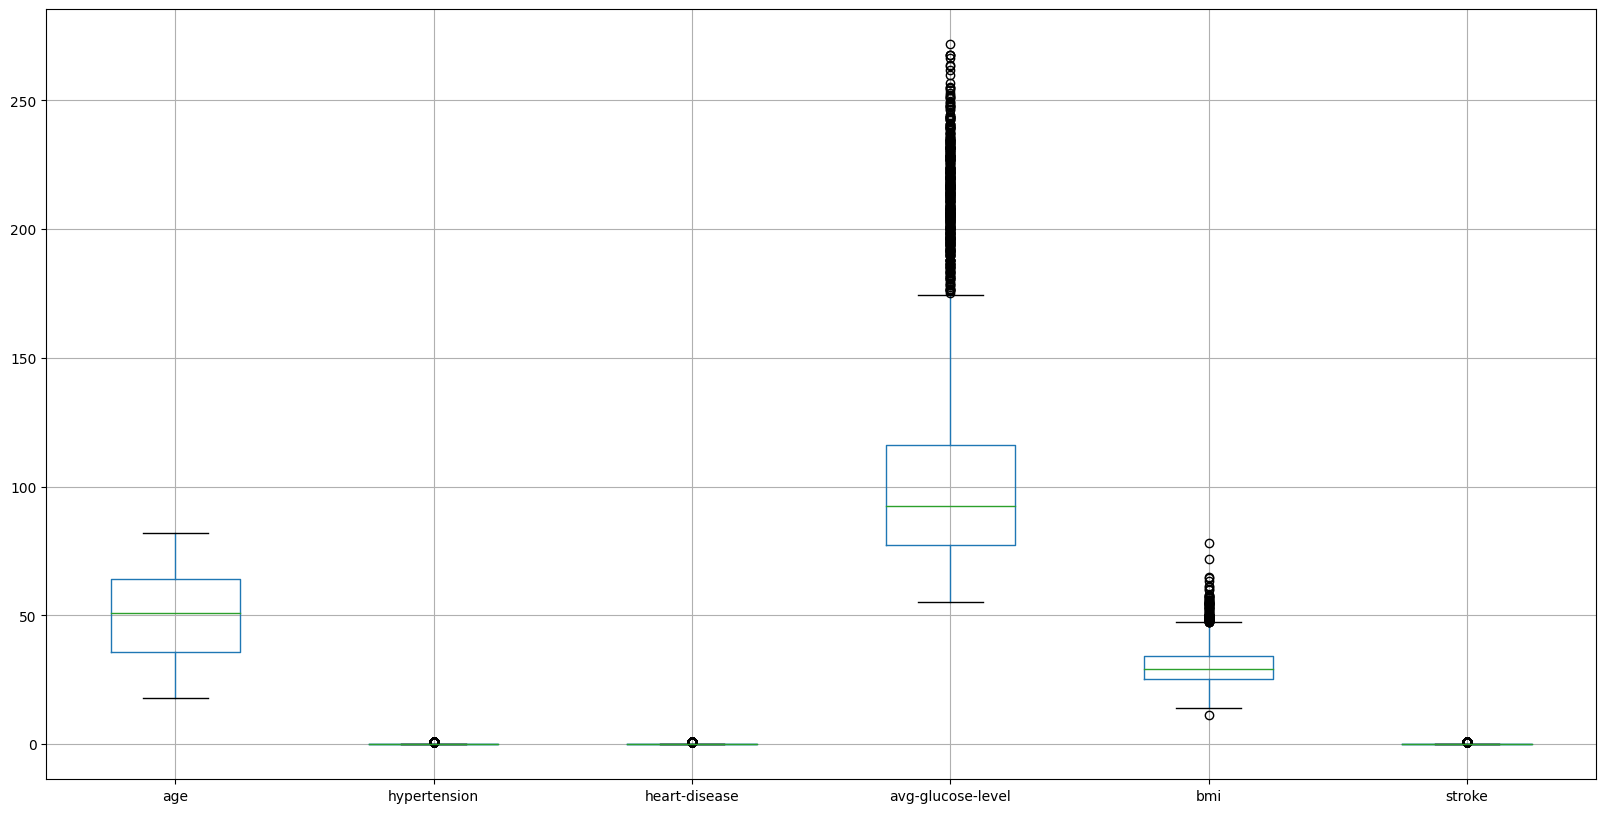

In [1556]:
dataset.boxplot(figsize=(20, 10))

In [1557]:
dataset.isna().sum()

gender               0
age                  0
hypertension         0
heart-disease        0
ever-married         0
work-type            0
Residence-type       0
avg-glucose-level    0
bmi                  0
smoking-status       0
stroke               0
dtype: int64

In [1558]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3254 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3254 non-null   object 
 1   age                3254 non-null   float64
 2   hypertension       3254 non-null   int64  
 3   heart-disease      3254 non-null   int64  
 4   ever-married       3254 non-null   object 
 5   work-type          3254 non-null   object 
 6   Residence-type     3254 non-null   object 
 7   avg-glucose-level  3254 non-null   float64
 8   bmi                3254 non-null   float64
 9   smoking-status     3254 non-null   object 
 10  stroke             3254 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 305.1+ KB
None


<AxesSubplot:xlabel='age_bucket', ylabel='count'>

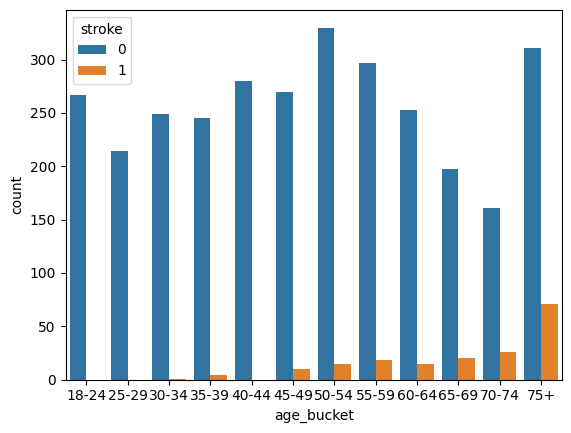

In [1559]:
dataset_copy['age_bucket'] = pd.cut(dataset['age'], bins=[17, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 100], labels=age_labels)
sns.countplot(x='age_bucket', order=age_labels, data=dataset_copy, hue='stroke')

<AxesSubplot:xlabel='bmi_bucket', ylabel='count'>

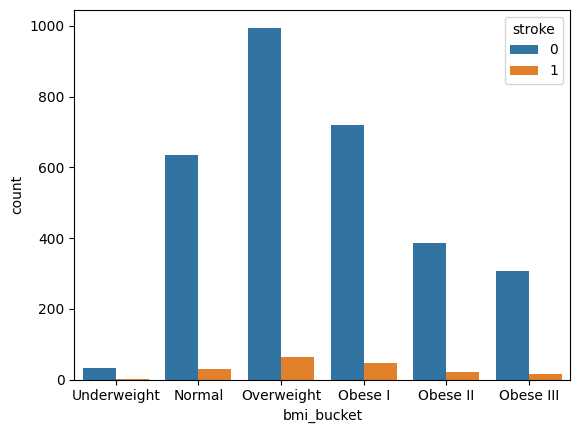

In [1560]:
dataset_copy['bmi_bucket'] = pd.cut(dataset_copy['bmi'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, 100], labels=bmi_labels)
sns.countplot(x='bmi_bucket', order=bmi_labels, data=dataset_copy, hue='stroke')

The BMI plot presents a clear outlier for a BMI of 92.0. We will remove this outlier from the dataset.

From this plot is difficult to see the real correlation between the features and the target variable. <br>
This is due to the fact that the dataset is unbalanced.

Age (years): This feature refers to the age of the participants who are over 18 years old.

Gender: This feature refers to the participant’s gender. The number of men is
1260, whereas the number of women is 1994.

Hypertension: This feature refers to whether this participant is hypertensive or
not. The percentage of participants who have hypertension is 12.54%.

Heart_disease: This feature refers to whether this participant suffers from heart
disease or not. The percentage of participants suffering from heart disease is 6.33%.

Ever married: This feature represents the marital status of the participants, 79.84%
of whom are married.

Work type: This feature represents the participant’s work status and has 4 categories
(private 65.02%, self-employed 19.21%, govt_job 15.67% and never_worked 0.1%).

Residence type: This feature represents the participant’s living status and has
2 categories (urban 51.14%, rural 48.86%).

Avg glucose level (mg/dL): This feature captures the participant’s average glucose level.

BMI (Kg/m2): This feature captures the body mass index of the participants.

Smoking Status: This feature captures the participant’s smoking status and has
3 categories (smoke 22.37%, never smoked 52.64% and formerly smoked 24.99%).

Stroke: This feature represents if the participant previously had a stroke or not.
The percentage of participants who have suffered a stroke is 5.53%

We can see that the minimum age in the cleaned dataset is 18, as required in the paper. <br>

### Dataset analysis

In [1561]:
# counting stroke
stroke_count =dataset['stroke'].value_counts()
# print(stroke_count)
print("Stroke fraction ", stroke_count[1]/(stroke_count[0]+stroke_count[1]))

# counting gender
gender_count = dataset['gender'].value_counts()
males_who_had_stroke = dataset[(dataset['gender'] == 'Male') & (dataset['stroke'] == 1)]
females_who_had_stroke = dataset[(dataset['gender'] == 'Female') & (dataset['stroke'] == 1)]
print('Males: ', gender_count['Male'])
print('Females: ', gender_count['Female'])

print("Percent of males in stroke: ", males_who_had_stroke.shape[0]/stroke_count[1])
print("Percent of females in stroke: ", females_who_had_stroke.shape[0]/stroke_count[1])

print("Incidence of stroke in males: ", males_who_had_stroke.shape[0]/gender_count['Male'])
print("Incidence of stroke in females: ", females_who_had_stroke.shape[0]/gender_count['Female'])

# counting hypertension
hypertension_count =dataset['hypertension'].value_counts()
# print(hypertension_count)
print("Hypertension fraction: ", hypertension_count[1]/(hypertension_count[0]+hypertension_count[1]))

# counting heart disease
heart_disease_count =dataset['heart-disease'].value_counts()
# print(heart_disease_count)
print("Hearth disease fraction: " ,heart_disease_count[1]/(heart_disease_count[0]+heart_disease_count[1]))

# counting ever married
ever_married_count =dataset['ever-married'].value_counts()
# print(ever_married_count)
print("Married fraction ", ever_married_count[0]/(ever_married_count[0]+ever_married_count[1]))

# counting work type
work_type_count =dataset['work-type'].value_counts()
# print(work_type_count)
print("Private fraction ", work_type_count[0]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))
print("Self Employed fraction ",work_type_count[1]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))
print("Gov fraction ",work_type_count[2]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))
print("Never Worked fraction ",work_type_count[3]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))

# counting residence type
residence_type_count =dataset['Residence-type'].value_counts()
# print(residence_type_count)
print("Urban fraction ", residence_type_count[0]/(residence_type_count[0]+residence_type_count[1]))
print("Rural fraction ", residence_type_count[1]/(residence_type_count[0]+residence_type_count[1]))

# counting smoking status
smoking_status_count =dataset['smoking-status'].value_counts()
# print(smoking_status_count)
print("Never Smoked fraction ", smoking_status_count[0]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))
print("Formely Smoked fraction ", smoking_status_count[1]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))
print("Smokes fraction ", smoking_status_count[2]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))


Stroke fraction  0.05531653349723417
Males:  1260
Females:  1994
Percent of males in stroke:  0.4166666666666667
Percent of females in stroke:  0.5833333333333334
Incidence of stroke in males:  0.05952380952380952
Incidence of stroke in females:  0.05265797392176529
Hypertension fraction:  0.12507682851874616
Hearth disease fraction:  0.06330669944683466
Married fraction  0.7984019668100799
Private fraction  0.6502765826674862
Self Employed fraction  0.19207129686539642
Gov fraction  0.15673017824216348
Never Worked fraction  0.0009219422249539029
Urban fraction  0.5113706207744315
Rural fraction  0.48862937922556854
Never Smoked fraction  0.5264290104486785
Formely Smoked fraction  0.24984634296250768
Smokes fraction  0.22372464658881377


C:\Users\hp\AppData\Local\Temp\ipykernel_20276\1802431490.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Married fraction ", ever_married_count[0]/(ever_married_count[0]+ever_married_count[1]))
C:\Users\hp\AppData\Local\Temp\ipykernel_20276\1802431490.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Private fraction ", work_type_count[0]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))
C:\Users\hp\AppData\Local\Temp\ipykernel_20276\1802431490.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

## Data preprocessing - Encoding, Scaling, Augmenting

### Splitting

In [1562]:
from sklearn.model_selection import train_test_split

features = np.array(dataset.columns[:-1])
print(features)

X = dataset[features]
y = dataset['stroke']

['gender' 'age' 'hypertension' 'heart-disease' 'ever-married' 'work-type'
 'Residence-type' 'avg-glucose-level' 'bmi' 'smoking-status']


In [1563]:
print(X)

      gender   age  hypertension  heart-disease ever-married      work-type  \
0       Male  67.0             0              1          Yes        Private   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
5       Male  81.0             0              0          Yes        Private   
...      ...   ...           ...            ...          ...            ...   
5100    Male  82.0             1              0          Yes  Self-employed   
5102  Female  57.0             0              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   

     Residence-type  avg-glucose-level   bmi   smok

### Encoding

In [1564]:
from sklearn.preprocessing import OrdinalEncoder

features_to_encode = ["gender", "ever-married", "work-type", "Residence-type", "smoking-status"]

encoder = OrdinalEncoder()

X[features_to_encode] = encoder.fit_transform(X[features_to_encode])

C:\Users\hp\AppData\Local\Temp\ipykernel_20276\2218277464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features_to_encode] = encoder.fit_transform(X[features_to_encode])


In [1565]:
print(X.shape)
print(y.shape)

(3254, 10)
(3254,)


In [1566]:
print(X)

      gender   age  hypertension  heart-disease  ever-married  work-type  \
0        1.0  67.0             0              1           1.0        2.0   
2        1.0  80.0             0              1           1.0        2.0   
3        0.0  49.0             0              0           1.0        2.0   
4        0.0  79.0             1              0           1.0        3.0   
5        1.0  81.0             0              0           1.0        2.0   
...      ...   ...           ...            ...           ...        ...   
5100     1.0  82.0             1              0           1.0        3.0   
5102     0.0  57.0             0              0           1.0        2.0   
5106     0.0  81.0             0              0           1.0        3.0   
5107     0.0  35.0             0              0           1.0        3.0   
5108     1.0  51.0             0              0           1.0        2.0   

      Residence-type  avg-glucose-level   bmi  smoking-status  
0                1.0   

### Scaling and Augmenting

In [1567]:
# Balance the dataset using SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

# We should normalize the data before augmenting the dataset

X_tmp = pd.DataFrame(X, columns=features)
gender = pd.get_dummies(X_tmp["gender"], prefix="gender")
married = pd.get_dummies(X_tmp["ever-married"], prefix="ever-married")
work = pd.get_dummies(X_tmp["work-type"], prefix="work-type")
residence = pd.get_dummies(X_tmp["Residence-type"], prefix="Residence-type")
smoking = pd.get_dummies(X_tmp["smoking-status"], prefix="smoking-status")

# the features that are one hot encoded
one_hot_features = ["gender", "ever-married", "work-type", "Residence-type", "smoking-status"]
X_tmp.drop(columns=one_hot_features, inplace=True) # drop the not one hot encoded features from the original dataframe, not needed anymore

# the matrix of features that are one hot encoded
X_tmp_0 = pd.concat([gender, married, work, residence, smoking], axis=1)
dummies_columns = X_tmp_0.columns

# concatenate the one hot encoded features with the original dataframe
X_tmp = pd.concat([X_tmp, X_tmp_0], axis=1)
tmp_features = X_tmp.columns

# Normalize the data
scaler = RobustScaler()
X_tmp = scaler.fit_transform(X_tmp, y)

# Apply SMOTE
smote = SMOTE(k_neighbors=3, random_state=0, sampling_strategy=1)
X_smote, y_smote = smote.fit_resample(X_tmp, y)

# descaling the data
X_smote = scaler.inverse_transform(X_smote)

# convert to dataframe
X_smote = pd.DataFrame(X_smote, columns=tmp_features)

In [1568]:
X_smote = np.round(X_smote)
dummies = pd.from_dummies(X_smote[dummies_columns], sep='_')
print(dummies)
X_smote.drop(columns=dummies_columns, inplace=True)
X_smote = pd.concat([X_smote, dummies], axis=1)

print(X_smote)

     gender ever-married work-type Residence-type smoking-status
0       1.0          1.0       2.0            1.0            0.0
1       1.0          1.0       2.0            0.0            1.0
2       0.0          1.0       2.0            1.0            2.0
3       0.0          1.0       3.0            0.0            1.0
4       1.0          1.0       2.0            1.0            0.0
...     ...          ...       ...            ...            ...
6143    0.0          0.0       2.0            1.0            1.0
6144    1.0          1.0       2.0            0.0            0.0
6145    1.0          1.0       2.0            1.0            0.0
6146    0.0          1.0       3.0            1.0            0.0
6147    0.0          1.0       3.0            1.0            1.0

[6148 rows x 5 columns]
       age  hypertension  heart-disease  avg-glucose-level   bmi gender  \
0     67.0           0.0            1.0              229.0  37.0    1.0   
1     80.0           0.0            1.0      

In [1569]:
# return to original data classes
X = X_smote
y = y_smote
X[features_to_encode] = encoder.inverse_transform(X[features_to_encode])

In [1570]:
print(X)

       age  hypertension  heart-disease  avg-glucose-level   bmi  gender  \
0     67.0           0.0            1.0              229.0  37.0    Male   
1     80.0           0.0            1.0              106.0  32.0    Male   
2     49.0           0.0            0.0              171.0  34.0  Female   
3     79.0           1.0            0.0              174.0  24.0  Female   
4     81.0           0.0            0.0              186.0  29.0    Male   
...    ...           ...            ...                ...   ...     ...   
6143  78.0           1.0            0.0              127.0  20.0  Female   
6144  70.0           0.0            0.0              215.0  34.0    Male   
6145  67.0           0.0            1.0              223.0  37.0    Male   
6146  72.0           0.0            0.0              196.0  33.0  Female   
6147  77.0           0.0            0.0               85.0  24.0  Female   

     ever-married      work-type Residence-type   smoking-status  
0             Yes   

In [1571]:
dataset_balanced = pd.DataFrame(X, columns=features)
dataset_balanced['stroke'] = y_smote
print(dataset_balanced.describe())
print(dataset_balanced.shape)

dataset_bal_copy = dataset_balanced.copy()

               age  hypertension  heart-disease  avg-glucose-level  \
count  6148.000000   6148.000000    6148.000000        6148.000000   
mean     58.757807      0.202180       0.116298         122.378822   
std      17.107638      0.401658       0.320608          57.101975   
min      18.000000      0.000000       0.000000          55.000000   
25%      47.000000      0.000000       0.000000          80.000000   
50%      61.000000      0.000000       0.000000          99.000000   
75%      74.000000      0.000000       0.000000         173.000000   
max      82.000000      1.000000       1.000000         272.000000   

               bmi       stroke  
count  6148.000000  6148.000000  
mean     30.559694     0.500000  
std       6.451520     0.500041  
min      12.000000     0.000000  
25%      26.000000     0.000000  
50%      30.000000     0.500000  
75%      34.000000     1.000000  
max      78.000000     1.000000  
(6148, 11)


In [1572]:
print(dataset.describe())

               age  hypertension  heart-disease  avg-glucose-level  \
count  3254.000000   3254.000000    3254.000000        3254.000000   
mean     50.449600      0.125077       0.063307         108.820089   
std      17.575302      0.330857       0.243551          48.329489   
min      18.000000      0.000000       0.000000          55.120000   
25%      36.000000      0.000000       0.000000          77.237500   
50%      51.000000      0.000000       0.000000          92.685000   
75%      64.000000      0.000000       0.000000         116.225000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  3254.000000  3254.000000  
mean     30.516841     0.055317  
std       7.143181     0.228632  
min      11.500000     0.000000  
25%      25.500000     0.000000  
50%      29.300000     0.000000  
75%      34.300000     0.000000  
max      78.000000     1.000000  


<AxesSubplot:xlabel='stroke', ylabel='count'>

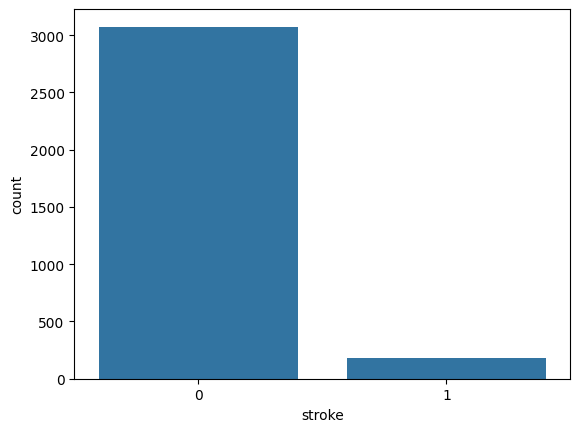

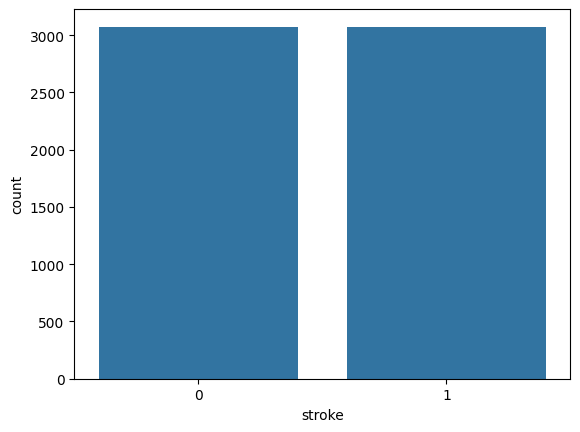

In [1573]:
sns.countplot(x='stroke', data=dataset)
plt.figure()
sns.countplot(x='stroke', data=dataset_balanced)

As we can see, the dataset is now balanced, and we can proceed with the training of the model.

## Data visualization

Now we can visualize the data to get a better understanding of the dataset. <br>
In particular, the trend of stroke is clearly correlated to age and more visible in the data.

<AxesSubplot:xlabel='age_bucket', ylabel='percent'>

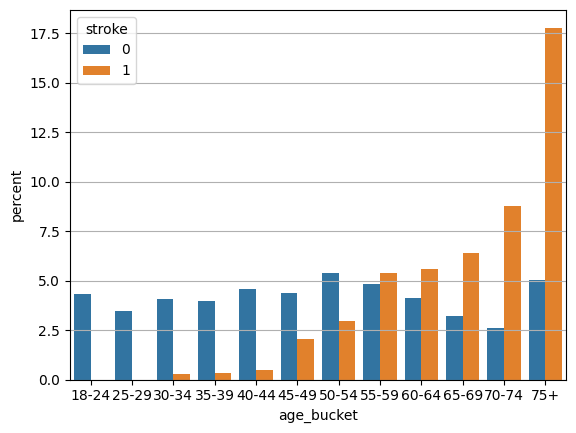

In [1574]:
plt.grid()
dataset_bal_copy['age_bucket'] = pd.cut(dataset_bal_copy['age'], bins=[17, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 100], labels=age_labels)
sns.countplot(x='age_bucket', hue='stroke', order=age_labels, data=dataset_bal_copy, stat='percent')

In [1575]:
elderies = dataset_bal_copy['age_bucket'].value_counts()
eldery_stroke = dataset_bal_copy[(dataset_bal_copy['age_bucket'] == '75+') & (dataset_bal_copy['stroke'] == 1)].shape[0]
print(elderies)
print(eldery_stroke)
print(eldery_stroke/elderies['75+'])

age_bucket
75+      1405
70-74     700
55-59     627
60-64     597
65-69     590
50-54     511
45-49     397
40-44     309
18-24     267
30-34     266
35-39     265
25-29     214
Name: count, dtype: int64
1094
0.7786476868327402


Another way to visualize the same data is to color the percentage of stroke in the dataset per age-group. <br>

In [1576]:
# counting stroke
stroke_count = dataset_balanced['stroke'].value_counts()
# print(stroke_count)
print("Stroke fraction ", stroke_count[1]/(stroke_count[0]+stroke_count[1]))

# counting gender
gender_count =  dataset_balanced['gender'].value_counts()
males_who_had_stroke =  dataset_balanced[( dataset_balanced['gender'] == 'Male') & ( dataset_balanced['stroke'] == 1)]
females_who_had_stroke =  dataset_balanced[( dataset_balanced['gender'] == 'Female') & ( dataset_balanced['stroke'] == 1)]
print('Males: ', gender_count['Male'])
print('Females: ', gender_count['Female'])

print("Percent of males who had a stroke in dataset: ", males_who_had_stroke.shape[0]/dataset_balanced.shape[0])
print("Percent of females who had a stroke in dataset: ", females_who_had_stroke.shape[0]/dataset_balanced.shape[0])

print("Percent of males in stroke: ", males_who_had_stroke.shape[0]/stroke_count[1])
print("Percent of females in stroke: ", females_who_had_stroke.shape[0]/stroke_count[1])

# from the data is clear that in the new dataset the incidence of stroke for men is 3% more than for women
print("Incidence of stroke in males: ", males_who_had_stroke.shape[0]/gender_count['Male'])
print("Incidence of stroke in females: ", females_who_had_stroke.shape[0]/gender_count['Female'])


Stroke fraction  0.5
Males:  2454
Females:  3694
Percent of males who had a stroke in dataset:  0.20640858815875082
Percent of females who had a stroke in dataset:  0.2935914118412492
Percent of males in stroke:  0.41281717631750164
Percent of females in stroke:  0.5871828236824984
Incidence of stroke in males:  0.5171149144254279
Incidence of stroke in females:  0.4886302111532214


<AxesSubplot:xlabel='gender', ylabel='percent'>

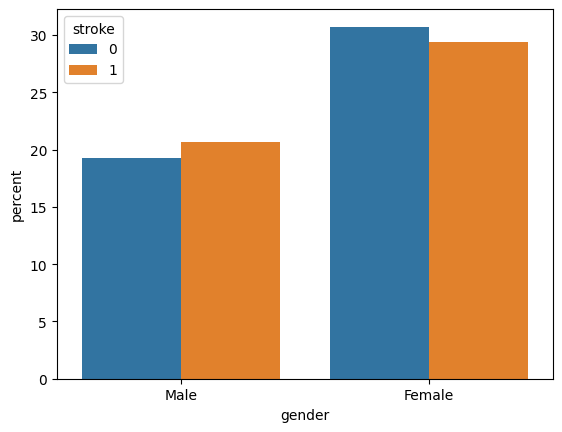

In [1577]:
sns.countplot(x='gender', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='hypertension', ylabel='percent'>

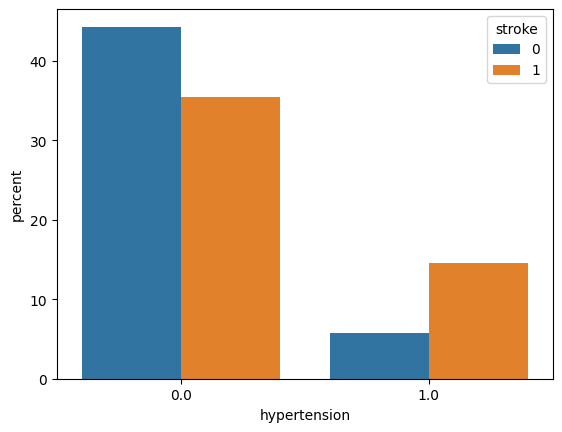

In [1578]:
sns.countplot(x='hypertension', hue='stroke', data=dataset_balanced, stat='percent')

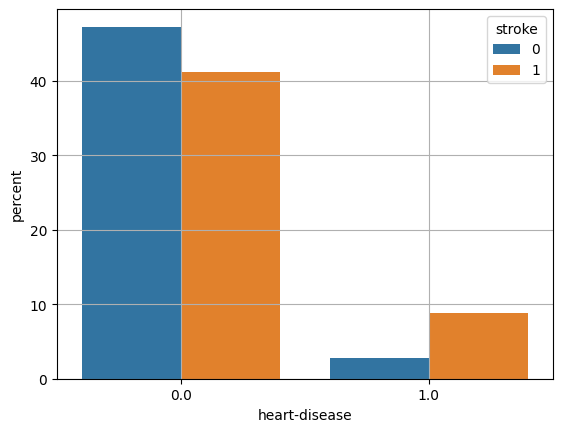

In [1579]:
sns.countplot(x='heart-disease', hue='stroke', data=dataset_balanced, stat='percent')
plt.grid()

<AxesSubplot:xlabel='ever-married', ylabel='percent'>

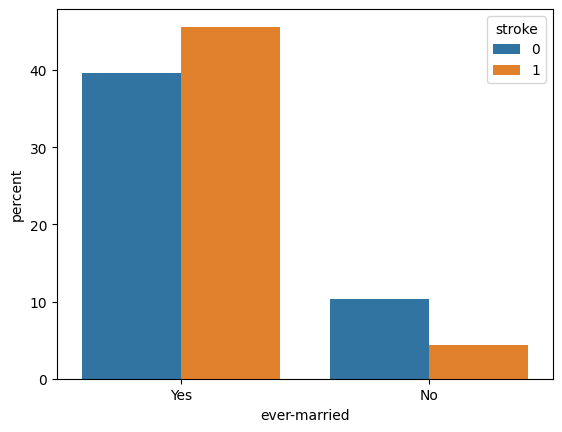

In [1580]:
sns.countplot(x='ever-married', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='work-type', ylabel='percent'>

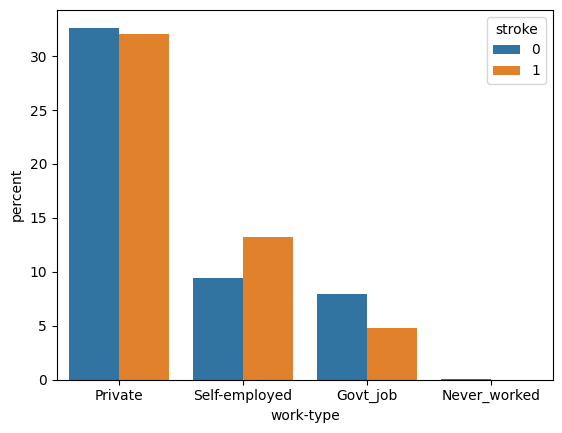

In [1581]:
sns.countplot(x='work-type', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='Residence-type', ylabel='percent'>

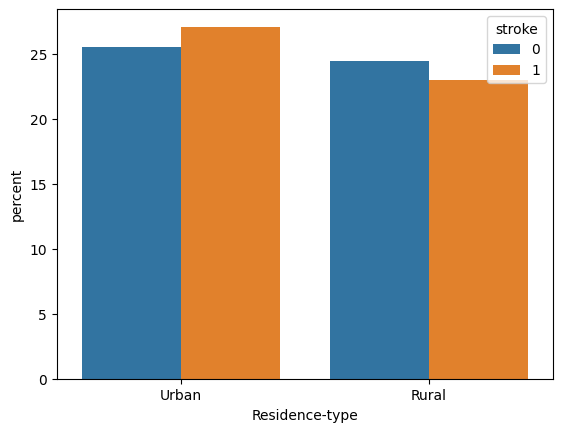

In [1582]:
sns.countplot(x='Residence-type', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='smoking-status', ylabel='percent'>

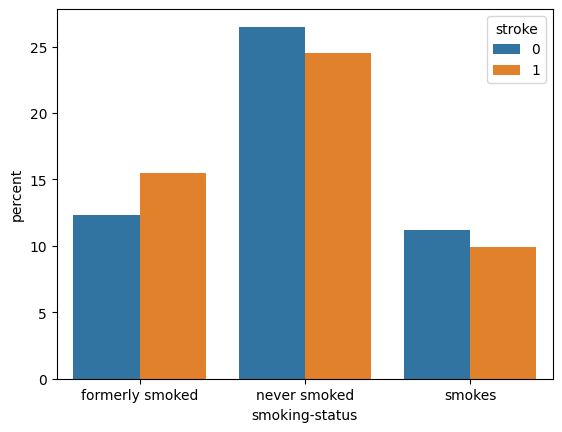

In [1583]:
sns.countplot(x='smoking-status', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='bmi_bucket', ylabel='percent'>

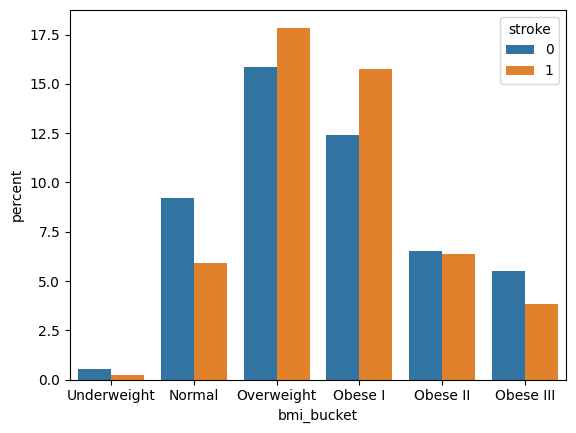

In [1584]:
dataset_bal_copy['bmi_bucket'] = pd.cut(dataset_bal_copy['bmi'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, 100], labels=bmi_labels)
sns.countplot(x='bmi_bucket', hue='stroke',order=bmi_labels,  data=dataset_bal_copy, stat='percent')

## Dividing the dataset in training and testing set

We will divide the dataset in training and testing set, using a 80-20 split, and train the model on the training set.

In [1585]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [1586]:
print(X_train)
print(y_train)

print(X_train.shape)
print(y_train.shape)

       age  hypertension  heart-disease  avg-glucose-level   bmi  gender  \
6046  76.0           1.0            0.0              196.0  30.0    Male   
3081  22.0           0.0            0.0               75.0  28.0  Female   
2354  74.0           0.0            0.0               73.0  28.0  Female   
2058  50.0           0.0            0.0               92.0  21.0  Female   
2014  64.0           0.0            0.0               56.0  43.0  Female   
...    ...           ...            ...                ...   ...     ...   
2909  37.0           0.0            0.0               77.0  35.0  Female   
5799  77.0           1.0            0.0              200.0  24.0  Female   
3333  62.0           0.0            1.0              199.0  40.0    Male   
4510  54.0           0.0            0.0              100.0  36.0    Male   
766   80.0           0.0            0.0               79.0  24.0    Male   

     ever-married      work-type Residence-type   smoking-status  
6046          Yes  S

PROBLEM: Currently the augmentation through SMOTE is not working. Whenever I balance the 'stroke' column, the other columns lose their correlation to 'stroke'. <br>

<AxesSubplot:>

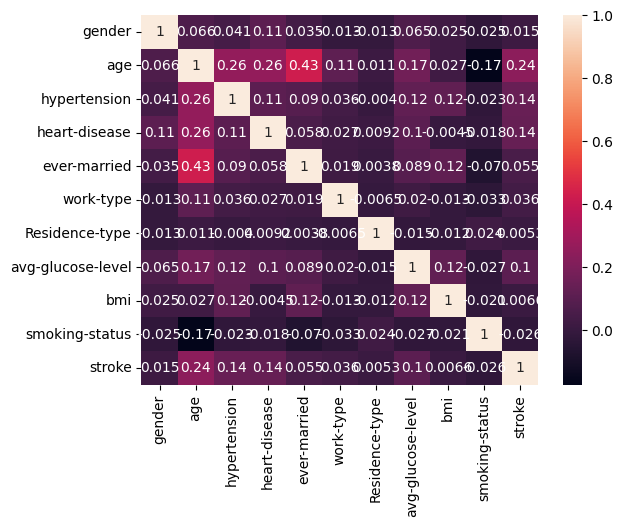

In [1587]:
df = dataset
X = encoder.fit_transform(df)
X = pd.DataFrame(X, columns=df.columns)
sns.heatmap(X.corr(), annot=True)

<AxesSubplot:>

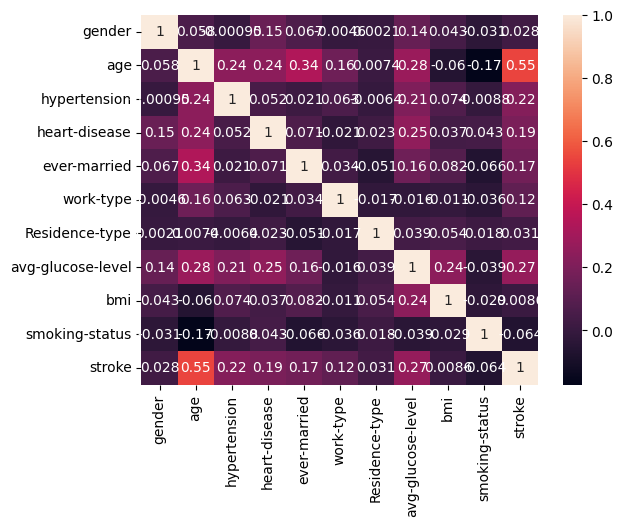

In [1588]:
df = dataset_balanced
X = encoder.fit_transform(df)
X = pd.DataFrame(X, columns=df.columns)
sns.heatmap(X.corr(), annot=True)

This is clear from the plot of the correlation matrix, where the correlation between the features and the target variable is lost for the gender variable in the dataset. <br>